# Applying Gaussian Coupola SDG Method on Law School Admissions Bar Passage Dataset



## Description of the nootebook

In this notebook, synthetic data is generated for Law School Admissions dataset. A Law School Admissions dataset from the Law School Admissions Council (LSAC). From 1991 through 1997, LSAC tracked some twenty-seven thousand law students through law school, graduation, and sittings for bar exams. The result was the most comprehensive database that exists on the demography, experiences, and outcomes of a large cohort of aspiring lawyers. While the data has important limitations, it is a unique and very valuable source for studying a range of issues related to legal education. The dataset was originally collected for a study called 'LSAC National Longitudinal Bar Passage Study' by Linda Wightman in 1998.

##### dataset source: https://www.kaggle.com/datasets/danofer/law-school-admissions-bar-passage/data


## Table of contents

0. Import libraries and data
1. Data description
2. Data cleaning
3. Correlation plot
4. Creating metadata
5. Gaussian copula fitting
6. Evaluating produced synthetic data

## 0. Import libraries and data

In [1]:
import json
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sdv.metadata import SingleTableMetadata, MultiTableMetadata
from sklearn.preprocessing import OneHotEncoder
from sdv.single_table import GaussianCopulaSynthesizer
from sdmetrics.reports.single_table import QualityReport
from sdmetrics.visualization import get_column_plot,set_plotly_config
from sdv.evaluation.single_table import run_diagnostic, evaluate_quality
from sdmetrics.single_table import BinaryAdaBoostClassifier, CategoricalCAP, CategoricalEnsemble, NumericalSVR
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
warnings.filterwarnings('ignore')

print('libraries imported')

libraries imported


In [2]:
#load the dataset
dataset_path = '../Dataset/bar_pass_prediction.csv'
original_data = pd.read_csv(dataset_path)
# Make a copy of the dataset
data_full = original_data.copy()

There are many features but we will keep only the following in the upcoming exploration:

ugpa - This one stands for undergraduate gpa. Every other feature with gpa in it either perfectly correlates or perfectly negatively correlates with ugpa and this is the one I decided to keep.

decile1, decile1b, decile3 - These features represent the law school rankings by decile of each candidate in years 1 and 3 (and I’m assuming year one second semester, but I can’t be sure about that).

lsat - This feature is obviously the LSAT score of each candidate, but oddly it’s not formatted in the 120 to 180 score range of the actual LSAT. That said it has a strong correlation to whether someone passed the bar and, well, the feature is called lsat!

grad - This seems to be whether the student who took the bar exam graduated from law school. It’s a binary variable and there are very few 0s, so that makes the most sense. (Special kudos to the 65 students surveyed who didn’t graduate law school, but still managed to pass the bar!)

fulltime - Was the student a full-time student.

fam_inc - This feature is family income by quintile.

tier - What tier law school did the student attend by quintile.

race1 - Categorizes students by race. Of all the race variables this was the most complete, so it’s the one I kept. All the information contained in the other race variables are contained in race1.

sex - student gender.

pass_bar - This is the target variable. Did the student pass the bar.

## 1. Data description

In [3]:
# Check all columns available
data_full.columns

Index(['decile1b', 'decile3', 'ID', 'decile1', 'sex', 'race', 'cluster',
       'lsat', 'ugpa', 'zfygpa', 'DOB_yr', 'grad', 'zgpa', 'bar1', 'bar1_yr',
       'bar2', 'bar2_yr', 'fulltime', 'fam_inc', 'age', 'gender', 'parttime',
       'male', 'race1', 'race2', 'Dropout', 'other', 'asian', 'black', 'hisp',
       'pass_bar', 'bar', 'bar_passed', 'tier', 'index6040', 'indxgrp',
       'indxgrp2', 'dnn_bar_pass_prediction', 'gpa'],
      dtype='object')

In [4]:
# List of columns to keep
columns_to_keep = [
    'pass_bar',  'ugpa', 'decile1', 'decile1b',
    'decile3', 'lsat', 'grad', 'fulltime', 'fam_inc',
    'tier', 'race1', 'gender'
]



df = data_full[columns_to_keep]

In [5]:
# Check the shape and names of the columns left
print(df.shape)
print(df.columns)

(22407, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')


## 2. Data cleaning

In [6]:
# Check how many rows with missing values are there
print(df.isnull().sum())


pass_bar       0
ugpa           0
decile1     1092
decile1b    1604
decile3     1604
lsat           0
grad           3
fulltime      34
fam_inc      289
tier          96
race1         16
gender         5
dtype: int64


In [7]:
# Inspect the dataframe
display(df.head())

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,Y,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,Y,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,Y,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,Y,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,Y,1.0,4.0,5.0,white,male


In [8]:
# Remove all rows with missing values
initial_row_count = df.shape[0]
df = df.dropna()
removed_rows = initial_row_count - df.shape[0]
print(f"Removed {removed_rows} rows with missing values.")

Removed 1895 rows with missing values.


In [9]:
# Check if all the rows with missing values are removed
print(df.shape)
print(df.columns)
print(df.isnull().sum())


(20512, 12)
Index(['pass_bar', 'ugpa', 'decile1', 'decile1b', 'decile3', 'lsat', 'grad',
       'fulltime', 'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')
pass_bar    0
ugpa        0
decile1     0
decile1b    0
decile3     0
lsat        0
grad        0
fulltime    0
fam_inc     0
tier        0
race1       0
gender      0
dtype: int64


In [10]:
# Inspect the dataframe
display(df.head())

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.5,10.0,10.0,10.0,44.0,Y,1.0,5.0,4.0,white,female
1,1,3.5,5.0,5.0,4.0,29.0,Y,1.0,4.0,2.0,white,female
2,1,3.5,3.0,3.0,2.0,36.0,Y,1.0,1.0,3.0,white,male
3,1,3.5,7.0,7.0,4.0,39.0,Y,1.0,4.0,3.0,white,male
4,1,3.5,9.0,9.0,8.0,48.0,Y,1.0,4.0,5.0,white,male


#### Convert ordinal numerical columns to catagorical

In [11]:
# Check types of columns
print(df.dtypes)

pass_bar      int64
ugpa        float64
decile1     float64
decile1b    float64
decile3     float64
lsat        float64
grad         object
fulltime    float64
fam_inc     float64
tier        float64
race1        object
gender       object
dtype: object


In [12]:
df['pass_bar'].value_counts()

pass_bar
1    19469
0     1043
Name: count, dtype: int64

In [13]:
# Columns to convert to categorical
columns_to_convert = ['grad', 'race1', 'gender','decile1', 'decile1b', 'decile3', 'fulltime', 'fam_inc', 'tier', 'pass_bar']

# Convert columns to categorical
for column in columns_to_convert:
    df[column] = df[column].astype('category')

# Verify changes
print(df.dtypes)

pass_bar    category
ugpa         float64
decile1     category
decile1b    category
decile3     category
lsat         float64
grad        category
fulltime    category
fam_inc     category
tier        category
race1       category
gender      category
dtype: object


In [14]:
# Which colums are categorical
categorical_columns = df.select_dtypes(include=['category'])
print(categorical_columns.columns)

Index(['pass_bar', 'decile1', 'decile1b', 'decile3', 'grad', 'fulltime',
       'fam_inc', 'tier', 'race1', 'gender'],
      dtype='object')


## 3. Correlation plot

#### Distinguish cetegorical and numerical columns

In [15]:
# Select only the categorical columns
categorical_columns = df.select_dtypes(include=['category'])

# Loop through each categorical column and print value counts
for column in categorical_columns.columns:
    print(f"Value counts for column '{column}':")
    print(df[column].value_counts())

Value counts for column 'pass_bar':
pass_bar
1    19469
0     1043
Name: count, dtype: int64
Value counts for column 'decile1':
decile1
6.0     2183
5.0     2180
7.0     2174
8.0     2166
9.0     2161
10.0    2136
4.0     2113
3.0     2063
2.0     1912
1.0     1424
Name: count, dtype: int64
Value counts for column 'decile1b':
decile1b
5.0     2092
7.0     2080
6.0     2079
9.0     2073
8.0     2069
3.0     2054
4.0     2046
10.0    2038
2.0     2032
1.0     1949
Name: count, dtype: int64
Value counts for column 'decile3':
decile3
5.0     2093
7.0     2082
9.0     2081
4.0     2077
3.0     2070
6.0     2067
8.0     2054
10.0    2029
2.0     2015
1.0     1944
Name: count, dtype: int64
Value counts for column 'grad':
grad
Y    20512
Name: count, dtype: int64
Value counts for column 'fulltime':
fulltime
1.0    19009
2.0     1503
Name: count, dtype: int64
Value counts for column 'fam_inc':
fam_inc
4.0    9076
3.0    7349
2.0    1987
5.0    1684
1.0     416
Name: count, dtype: int64
Value co

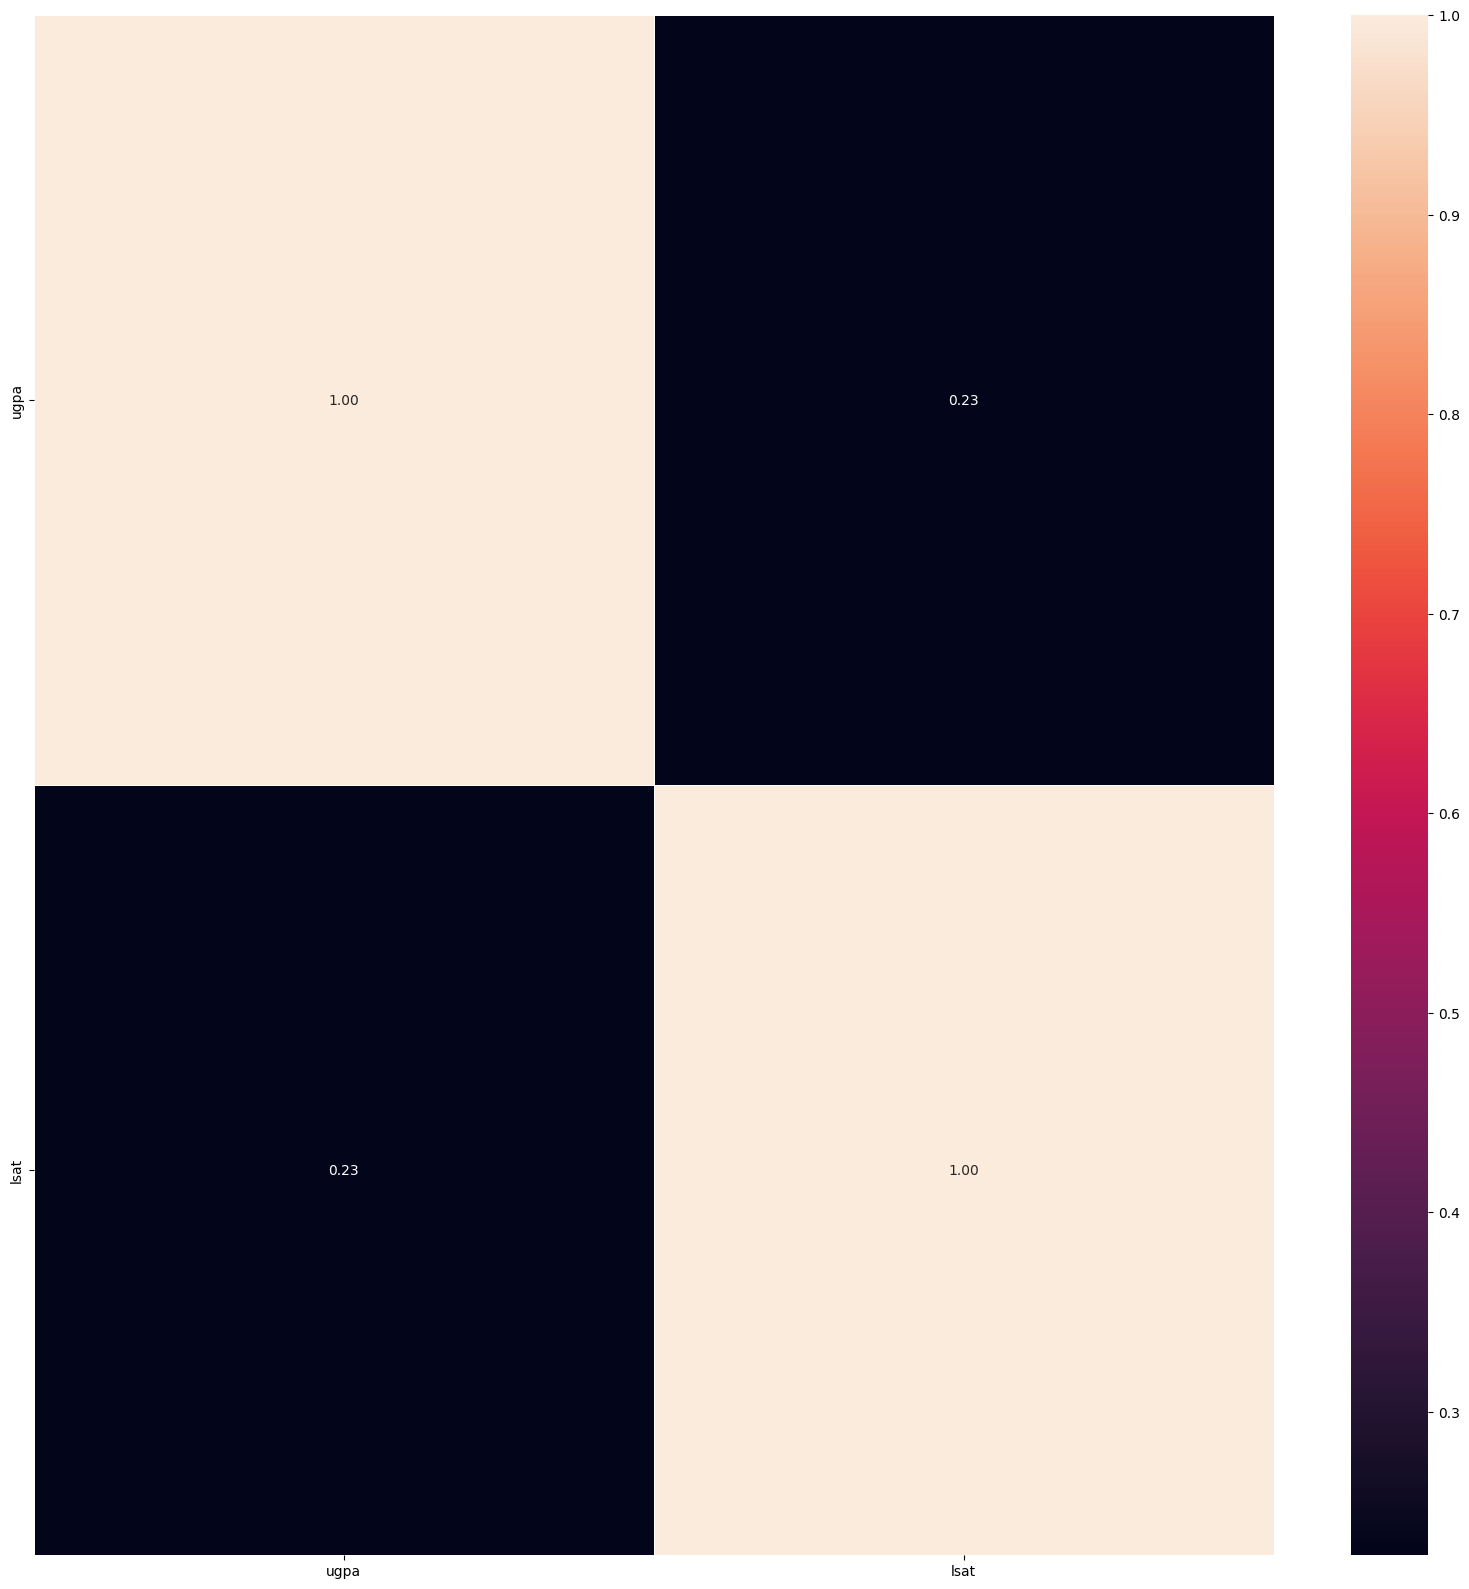

In [16]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(numeric_only=True), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

## 4. Creating metadata

##### Creating the metadata is necessary for sdv package which we will use for the Gaussian copula. This metadata contains a representation of the column types and the type of data used. 

In [17]:
# initializing metadata generator
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

In [18]:
metadata.validate()
#metadata.save_to_json('PLA_metadata.json') #uncomment this is you do not have it yet

## 5. Gaussian Copula fitting

A copula is a multivariate CDF, with uniform distributed marginals. This means that it encapsulates the joint distribution of the data. Our goal in using a copula for synthetic data generation, is to understand the joint distribution of the data and then generate samples from that joint distribution. 

The copula does not assume a specific form for the marginal distributions of each column, and allows us to seperate the estimation of the marginal distributions from that of the joint distribution. It works in two steps:

 * In a first step, the marginal distribution of each column is estimated, by using a Gaussian kernel density function (gaussian_kde). The samples are then transformed to a uniform distribution by using the probability integral transformation. 
 * In a second step, a joint Gaussian distribution is fitted on the (pseudo) transformed samples. 

By using a Gaussian copula, we are making some assumptions about the dependence structure of the data. In particular, regarding tail dependence, and how likely it is to have extreme values for the numeric variables happen at the same time. 

Produce the synthetic data using a Gaussian Coupola

In [19]:
# GC fitting
synthesizer = GaussianCopulaSynthesizer(metadata,  default_distribution="gaussian_kde")
synthesizer.fit(df)

Once the copula is fitted to the original data, we can sample as many synthetic data points as we want from the joint CDF. 

In [20]:
# create synthetic data and preview head
synthetic_data_GC = synthesizer.sample(num_rows=2000) # 20512 rows originally
synthetic_data_GC.head()

,pass_bar,ugpa,decile1,decile1b,decile3,lsat,grad,fulltime,fam_inc,tier,race1,gender
0,1,3.6,2.0,8.0,6.0,37.5,Y,1.0,3.0,3.0,white,male
1,1,2.9,9.0,8.0,6.0,32.0,Y,1.0,4.0,3.0,white,male
2,0,2.4,2.0,8.0,9.0,30.3,Y,1.0,4.0,3.0,white,male
3,1,3.7,7.0,5.0,2.0,34.6,Y,1.0,4.0,4.0,white,female
4,1,3.7,5.0,9.0,6.0,35.6,Y,1.0,4.0,3.0,white,male


In [21]:
# store synthetic data
synthetic_data_GC.to_csv('C:/Users/20181588/Desktop/AA SDG/synthetic-data-generation/Law School Admissions Bar Passage/Dataset/bar_pass_prediction_SD2k.csv')

## 6. Evaluating produced synthetic data

The diagnostic reports data qvalidity and structure. Data validity means that primary keys must be unique and non-null; continuous values in the synthetic data must adhere to the min/max range in the real data; discrete values in the synthetic data must adhere to the same categories as the real data. Data structure checks that the real and synthtetic data have the same column names. 

In [22]:
# check on structure of data
diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    metadata=metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 104.83it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%


The column shape checks how close the marginal distributions for the real and synthetic data are. column pair trendschecks the statistical similarity between pairs of columns in the real and synthetic data. 

In [23]:
# check on univariate and bivariate distributions
quality_report = evaluate_quality(
    df,
    synthetic_data_GC,
    metadata
)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 66/66 [00:02<00:00, 25.07it/s]

Overall Score: 78.78%

Properties:
- Column Shapes: 95.65%
- Column Pair Trends: 61.91%


In [24]:
# univariate quality report
quality_report.get_details('Column Shapes')

,Column,Metric,Score
0,pass_bar,TVComplement,0.997152
1,ugpa,KSComplement,0.987996
2,decile1,TVComplement,0.899846
3,decile1b,TVComplement,0.935960
4,decile3,TVComplement,0.907595
5,lsat,KSComplement,0.954037
6,grad,TVComplement,1.000000
7,fulltime,TVComplement,0.989726
8,fam_inc,TVComplement,0.941751
9,tier,TVComplement,0.938715


For numerical columns, The KSComplement returns 1-(KS statistics) where the Kolmogorov Smirnov (KS) statistic is the maximal difference between the CDF of the variable in the original and the synthetic data. A value close to 1 represents a better fit.

For categorical columns, The TVComplement returns 1 - (TV Distance), where the Total Variation Distance measures the relative frequencies of the categories of a given variable in the original and the synthetic data. A value close to 1 represents a better fit

In [25]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='ugpa'
)

fig.show()

In [26]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='lsat'
)

fig.show()

In [27]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='pass_bar'
)

fig.show()

In [28]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile1'
)

fig.show()

In [29]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile1b'
)

fig.show()

In [30]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='decile3'
)

fig.show()

In [31]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='grad'
)

fig.show()

In [32]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='fulltime'
)

fig.show()

In [33]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='fam_inc'
)

fig.show()

In [34]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='tier'
)

fig.show()

In [35]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='race1'
)

fig.show()

In [36]:
fig = get_column_plot(
    real_data=df,
    synthetic_data=synthetic_data_GC,
    column_name='gender'
)

fig.show()

#### Statistical tests for univariate distributions

In [37]:
from scipy.stats import ks_2samp, chi2_contingency

# Define continuous variables
continuous_vars = ['ugpa', 'lsat']

# Apply KS test to continuous variables
for column in continuous_vars:
    ks_statistic, ks_p_value = ks_2samp(df[column], synthetic_data_GC[column])
    print(f"KS Statistic for {column}: {ks_statistic}, P-value: {ks_p_value}")

KS Statistic for ugpa: 0.012003900156006275, P-value: 0.9526126829808064
KS Statistic for lsat: 0.0459625585023401, P-value: 0.000877575000812711


In [38]:
# Degfine categorical variables
categorical_vars = ['decile1', 'decile1b', 'decile3', 'grad', 'fulltime', 'fam_inc', 'tier', 'race1', 'gender', 'pass_bar']


# Apply Chi-squared test to categorical variables
for column in categorical_vars:
    # Create a contingency table
    contingency_table = pd.crosstab(df[column], synthetic_data_GC[column])
    
    # Run the Chi-squared test
    chi2_stat, chi2_p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-squared Statistic for {column}: {chi2_stat}, P-value: {chi2_p}")

Chi-squared Statistic for decile1: 77.29777872450552, P-value: 0.5959263187632968
Chi-squared Statistic for decile1b: 100.09199453525703, P-value: 0.07387062092580836
Chi-squared Statistic for decile3: 90.74588072958366, P-value: 0.2150873329565216
Chi-squared Statistic for grad: 0.0, P-value: 1.0
Chi-squared Statistic for fulltime: 0.8875471862309382, P-value: 0.34614286379004744
Chi-squared Statistic for fam_inc: 8.504830471482686, P-value: 0.9323984716875963
Chi-squared Statistic for tier: 17.99800432560409, P-value: 0.8424754215987458
Chi-squared Statistic for race1: 16.509149334888047, P-value: 0.41802537318421845
Chi-squared Statistic for gender: 0.018108359863191197, P-value: 0.8929539924109825
Chi-squared Statistic for pass_bar: 0.2780754315454351, P-value: 0.5979654304142618


## Multivariate checks 

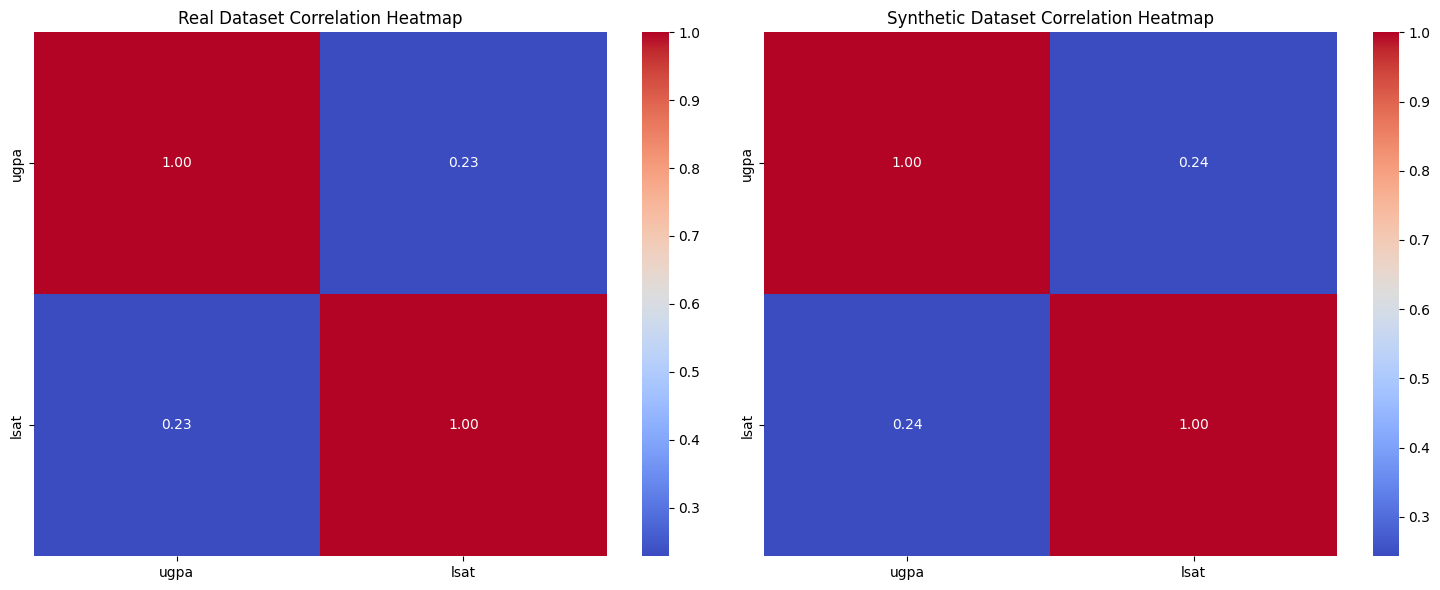

In [39]:
# Create subplots for side-by-side comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot correlation heatmap for the real dataset
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0])
axes[0].set_title('Real Dataset Correlation Heatmap')

# Plot correlation heatmap for the synthetic dataset
sns.heatmap(synthetic_data_GC.corr(numeric_only=True), cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1])
axes[1].set_title('Synthetic Dataset Correlation Heatmap')

plt.tight_layout()
plt.show()

We can observe that the correlation between the numerical columns in the original and synthetic datasets are very well preserved. 

# ML efficacy

Some times, the goal of producing synthetic datasets is to solve some downstream machine learning task. This could be a classification problem in our case, so a way to test how well the synthetic datasets are is to split both the original and synthetic datasets into train and test sets. Next, we can fit the ML model to the train portion of the synthetic data and evaluate it on the test portion of the real data. If the synthetic data is close to the  real data, then the capability (f1-score) of the model shouldbe high. 

In [40]:
BinaryAdaBoostClassifier.compute(df, synthetic_data_GC, target = 'pass_bar', scorer = [f1_score])

(0.9738316821775242,)

# Privacy 

First we can check if there are any rows in the original data that are found in the synthetic data

In [41]:
# Check if there are any matching rows in the two dataframes
matching_rows = df.isin(synthetic_data_GC).all(axis=1)

# Print the number of matching rows
print("Number of matching rows: ", matching_rows.sum())

Number of matching rows:  0


Next, We can imagine that an attacker already has access to some parts of the dataset. This could e.g. be access to some of the columns in the real data. If the attacker also has access to the full synthetic data, We would like to know how likely it is that they could then recover the remaining original data.  It works in the following way 

Identify a row (let's call it r) in the original dataset. Record all the key fields present in 

Search through the synthetic dataset to find all rows that share the same key fields as r. This group of rows is referred to as the "equivalence class" of r in the synthetic data.

Within this equivalence class, each row contains synthetic values for the sensitive fields. Each of these synthetic values "votes" to guess the sensitive fields of the original row r.

Calculate the final score by determining the frequency of votes that correctly match all sensitive fields of the original row 
r. This score ranges between 0 and 1, indicating the accuracy of the synthetic data in replicating sensitive field values from the original dataset.

A score closer to one indicates that the the attacker is not able to correctly guess any of the sensitive values. 

In [42]:
score = CategoricalCAP.compute(
    real_data= df,
    synthetic_data=synthetic_data_GC,
    key_fields=['race1', 'tier'], # the column names that the attacker already knows. 
    sensitive_fields=['fam_inc']  # the column names that the attacker wants to guess.
)
score

0.6332337957283065